<a href="https://colab.research.google.com/github/Anupam-Durutkar/Credit-Card-Default-Prediction-Analysis/blob/main/Part_2_Modeling_Credit_Card_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# **Part 2 - Modeling: Credit Card Default Prediction**

---



## Table of Contents
- Import Packages
- Load Data
- Prepare for Modeling
- Predicative Classification Modeling
- Logistic Regression
- Random Forest
- XGBoost
- Model Comparison
- Conclusion

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import warnings
warnings.simplefilter("ignore")
from pprint import pprint

import joblib
import imblearn

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn import metrics  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project_folder/Supervised ML - Classification/Credit Card Default Prediction_Processed.csv")
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DEF_PAY_NMO'],
      dtype='object')

In [ ]:
print(data.shape)

(30000, 25)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           30000 non-null  int64
 1   LIMIT_BAL    30000 non-null  int64
 2   SEX          30000 non-null  int64
 3   EDUCATION    30000 non-null  int64
 4   MARRIAGE     30000 non-null  int64
 5   AGE          30000 non-null  int64
 6   PAY_1        30000 non-null  int64
 7   PAY_2        30000 non-null  int64
 8   PAY_3        30000 non-null  int64
 9   PAY_4        30000 non-null  int64
 10  PAY_5        30000 non-null  int64
 11  PAY_6        30000 non-null  int64
 12  BILL_AMT1    30000 non-null  int64
 13  BILL_AMT2    30000 non-null  int64
 14  BILL_AMT3    30000 non-null  int64
 15  BILL_AMT4    30000 non-null  int64
 16  BILL_AMT5    30000 non-null  int64
 17  BILL_AMT6    30000 non-null  int64
 18  PAY_AMT1     30000 non-null  int64
 19  PAY_AMT2     30000 non-null  int64
 20  PAY_AM

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


## Prepare for Modeling

### 1. Feature Engineering

Covert categorical column into integer by using the LabelEncoder from sklearn 

In [ ]:
data['AGE']

0        24
1        26
2        34
3        37
4        57
         ..
29995    39
29996    43
29997    37
29998    41
29999    46
Name: AGE, Length: 30000, dtype: int64

In [ ]:
# Bin ‘AGE’ data to 6 groups
bins= [21,30,40,50,60,70,80]
labels = list(range(6))
data['AGE'] = pd.cut(data['AGE'],bins=bins, labels=labels,right=False)

from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
data['AGE_Types_Cat'] = labelencoder.fit_transform(data['AGE'])
data['AGE_Types_Cat']

0        0
1        0
2        1
3        1
4        3
        ..
29995    1
29996    2
29997    1
29998    2
29999    2
Name: AGE_Types_Cat, Length: 30000, dtype: int64

In [ ]:
# Another way to covert categorical column into integer by extracting the code of the categories
# data.AGE = data.AGE.cat.codes

### 2. Feature Selection

In [ ]:
# Define predictor variables and target variable
X = data.drop(columns=['ID','AGE','DEF_PAY_NMO'])
y = data['DEF_PAY_NMO']

# Save all feature names as list
feature_cols = X.columns.tolist() 

# Extract numerical columns and save as a list for rescaling
X_num = X.drop(columns=['SEX', 'EDUCATION', 'MARRIAGE', 'AGE_Types_Cat'])
num_cols = X_num.columns.tolist()   

In [ ]:
num_cols

['LIMIT_BAL',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

### 3. Check Class Imbalance

0    77.88
1    22.12
Name: DEF_PAY_NMO, dtype: float64


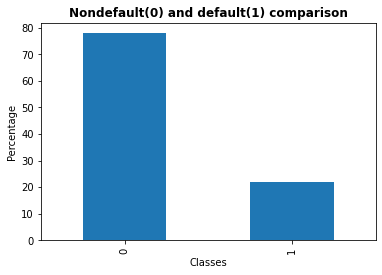

In [ ]:
# Check target classes balancec
cla_bal = data['DEF_PAY_NMO'].value_counts(normalize=True)*100
print(cla_bal)

# Plot the classes
cla_bal.plot(kind = 'bar')
plt.title('Nondefault(0) and default(1) comparison',fontweight = "bold")
plt.xlabel('Classes')
plt.ylabel('Percentage')
plt.show()

With typical default classification problems, we expect imbalanced classes as we know most people will not default. This dataset is also imbalanced, with 78% non-default vs. 22% default.

### 4. Split Training and Test Data


In [ ]:
# Define function to split data with and without SMOTE 
# Also used the Stratified Random Sampling 

def data_split(X, y, imbalance = False):
    # split data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)
    
    if imbalance:
        # use SMOTE to over sample data
        from imblearn.over_sampling import SMOTE
        sm = SMOTE(random_state = 42)
        X_train, y_train = sm.fit_resample(X_train, y_train) #.ravel())
    
    return X_train, X_test, y_train, y_test

### 5. Rescale Features

In [ ]:
# Define function to rescale training data using StandardScaler

def standard_scaler(X_train, X_test, numerical_cols):
    
    # Make copies of dataset
    X_train_std = X_train.copy()
    X_test_std = X_test.copy()
    
    # Apply standardization on numerical features only
    for i in numerical_cols:
        scl = StandardScaler().fit(X_train_std[[i]])     # fit on training data columns
        X_train_std[i] = scl.transform(X_train_std[[i]]) # transform the training data columns
        X_test_std[i] = scl.transform(X_test_std[[i]])   # transform the testing data columns
    
    return X_train_std,X_test_std

### Model Evaluation

In [ ]:
# Define a function to compute Precision, Recall and F1 score

def get_pre_rec_f1(Model_name,model,roc_auc,X_test,y_test):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)   
   
    model_result =  pd.DataFrame([[Model_name, accuracy,  precision,  recall, F1, roc_auc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'roc_auc Score'])
    
    return  model_result    
      
    #print(f'Precision:{precision:.3f}\nRecall:{recall:.3f}\nAccuracy score:{accuracy:.3f}\nF1 score:{F1:.3f}')

## Classification Predictive Modeling
1. Logistic Regression
2. Random Forest
3. XGBoost
4. Model Comparison

### 1. Logistic Regression

Rescaling the features variables then run Logistic Regression with and without SMOTE sampling to compare ROC_AUC scores.

In [ ]:
def run_logistic_regression(imbalance=False):
    # Split data  
    X_train, X_test, y_train, y_test = data_split(X, y, imbalance = imbalance)

    # Rescale data
    X_train_std, X_test_std = standard_scaler(X_train, X_test, numerical_cols = num_cols)
    
    # Instantiate model
    clf_lr = LogisticRegression(random_state=42)
    
    # Fit the model
    clf_lr.fit(X_train_std, y_train)

    # Use model's default parameters to get cross validation score
    scores = cross_val_score(clf_lr, X_train_std, y_train, scoring ="roc_auc", cv = 8)
    roc_auc_lr = np.mean(scores)
    
    if imbalance:
        return "Logistic Regression", "With SMOTE", roc_auc_lr
    else:
        return "Logistic Regression", "Without SMOTE", roc_auc_lr

model_result = []
model_result.append(run_logistic_regression())
model_result.append(run_logistic_regression(imbalance=True))

pd.DataFrame(model_result, columns = ["Model", "SMOTE", "ROC_AUC Score"])

,Model,SMOTE,ROC_AUC Score
0,Logistic Regression,Without SMOTE,0.724889
1,Logistic Regression,With SMOTE,0.798693


Since SMOTE sampling performed better on training data, we will use SMOTE sampling and initial best guess parameters to fit the model.

#### Tune Parameters of Logistic Regression with GridSearchCV

---



In [ ]:
logModel = LogisticRegression()

In [ ]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 200]
    }
]

More on Hyperparameters
* Solver: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451
* L1 and L2 Regularisation: https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
* Slearn Logistic Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Import Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

# Split data with SMOTE 
X_train, X_test, y_train, y_test = data_split(X, y, imbalance = True) 

# Rescale data
X_train_std, X_test_std = standard_scaler(X_train, X_test, numerical_cols = num_cols)

In [ ]:
clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [ ]:
#best_clf = clf.fit(X_train_std, y_train)

In [ ]:
#best_clf.best_params_

In [ ]:
#print(best_clf.best_score_)

#### Tune Parameters of Logistic Regression with RandomizedSearchCV

---



In [ ]:
# Randomized search for the best C parameter

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Split data with SMOTE 
X_train, X_test, y_train, y_test = data_split(X, y, imbalance = True) 

# Rescale data
X_train_std, X_test_std = standard_scaler(X_train, X_test, numerical_cols = num_cols)

logistic = LogisticRegression(solver='liblinear', max_iter=200,random_state=42)
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=42)

lr_best= clf.fit(X_train_std, y_train)   

print(lr_best.best_params_)
print(lr_best.best_score_)

{'C': 1.49816047538945, 'penalty': 'l2'}
0.7294711097523694


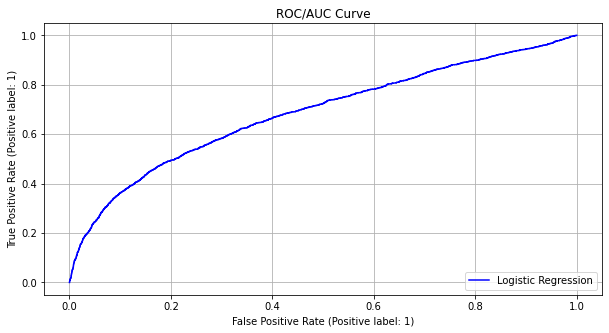

In [ ]:
# Plot ROC_AUC curve 
 
fig,ax=plt.subplots(figsize=(10,5))

plot_roc_curve(lr_best, X_test_std, y_test,ax=ax, color="blue",label='Logistic Regression')

plt.title('ROC/AUC Curve')
plt.grid()

In [ ]:
# Save tuned model and parameters

joblib.dump(lr_best,"logreg_sm_tuned.pkl") 

['logreg_sm_tuned.pkl']

In [ ]:
lr_best = joblib.load("logreg_sm_tuned.pkl")

In [ ]:
# Get ROC_AUC score of tuned model on training data
# To perform the evaluation, taking the dataset and cross-validation configuration and returning a list of scores calculated for each fold with mean.

scores_tuned = cross_val_score(lr_best, X_train_std, y_train, scoring = "roc_auc", cv = 5)
roc_auc_lr_best = np.mean(scores_tuned)

print(f'ROC_AUC score after tuning parameters:{roc_auc_lr_best:.3f}')

ROC_AUC score after tuning parameters:0.797


In [ ]:
# Save best ROC_AUC 

joblib.dump(roc_auc_lr_best,"logreg_ROC_AUC_CV.pkl") 

['logreg_ROC_AUC_CV.pkl']

In [ ]:
roc_auc_lr_best = joblib.load("logreg_ROC_AUC_CV.pkl")
roc_auc_lr_best

0.7970518179407691

After fine-tuning parameter C, Logistic Regression model got ROC_AUC training score as 0.79, slightly increased from original score 0.72. This could mean model is less overfitting the training data.

**`Model Result`**

---



In [ ]:
# Calculate precision and recall of Logistic Regression model

print('Logistic Regression model on test data:')
Logistic_Regression_Model = get_pre_rec_f1('Logistic Regression', lr_best,roc_auc_lr_best, X_test_std, y_test)
Logistic_Regression_Model

Logistic Regression model on test data:


,Model,Accuracy,Precision,Recall,F1 Score,roc_auc Score
0,Logistic Regression,0.689111,0.367488,0.562029,0.4444,0.797052


#### Model Performance:
The business nature of credit card default analysis requires model to have a high recall. Logstic Regression model has a recall as 0.566. Let's look at another model - Random Forest to see if we can get a better recall.

### 2. Random Forest

Tree based model does not need feature to be rescaled, so we will skip rescaling step.

In [ ]:
def run_random_forest(imbalance=False):
    # Split data  
    X_train, X_test, y_train, y_test = data_split(X, y, imbalance = imbalance)
    
    # Instantiate model
    clf_rf = RandomForestClassifier()
   
    # Fit the model
    clf_rf.fit(X_train, y_train)

    # Use model's default parameters to get cross validation score
    scores = cross_val_score(clf_rf, X_train, y_train, scoring ="roc_auc", cv = 5)
    roc_auc_rf = np.mean(scores)
    
    if imbalance:
        return "Random Forest", "With SMOTE", roc_auc_rf
    else:
        return "Random Forest", "Without SMOTE", roc_auc_rf

model_result = []
model_result.append(run_random_forest())
model_result.append(run_random_forest(imbalance=True))

pd.DataFrame(model_result, columns = ["Model", "SMOTE", "ROC_AUC Score"])

,Model,SMOTE,ROC_AUC Score
0,Random Forest,Without SMOTE,0.762552
1,Random Forest,With SMOTE,0.915451


Again, SMOTE sampling has a better performance. With the default parameters, Random Forest model generated ROC-AUC score 0.916 on training data, which is better than Logistic Regression model. Next, we will try to fine tune the hyperparameters with SMOTE sampling.

#### Tune Parameters of Random Forest

In [ ]:
# Split data with SMOTE
X_train_sm, X_test, y_train_sm, y_test = data_split(X, y, imbalance = True)

In [ ]:
# Create parameter grid  
param_grid = {
    'max_depth': [60, 90, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    #'n_estimators': [100, 200, 300]
}

# Instantiate the model
clf_rf = RandomForestClassifier()

# Instantiate grid search model
grid_search = GridSearchCV(estimator = clf_rf, param_grid = param_grid,    
                          cv = 3, n_jobs = -1, verbose = 1)

# Fit grid search to the data
grid_search.fit(X_train_sm, y_train_sm)
grid_search.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


{'max_depth': 60, 'min_samples_leaf': 3, 'min_samples_split': 8}

In [ ]:
# Save tuned model

joblib.dump(grid_search,"RandomForest_tuned_final.pkl")

['RandomForest_tuned_final.pkl']

In [ ]:
grid_search = joblib.load("RandomForest_tuned_final.pkl")

In [ ]:
# Use the best parameters to fit the model

rf_best = RandomForestClassifier(**grid_search.best_params_)   
rf_best.fit(X_train_sm,y_train_sm)

scores_best = cross_val_score(rf_best, X_train_sm, y_train_sm, scoring ="roc_auc", cv = 5)
roc_auc_best = np.mean(scores_best)

print(f'ROC_AUC training score after tuning for Random Forest: {roc_auc_best:.3f}')

ROC_AUC training score after tuning for Random Forest: 0.905


After tuning parameters, Random Forest model's ROC-AUC score decreased slightly to 0.905.

#### Random Forest Model Evaluation

**`Model Result`**

---
#### Precision_Recall and F1 Score

In [ ]:
# Compute precision, recall and F1 score of Random Forest model on test data

RandomForest_model = get_pre_rec_f1('Random Forest',rf_best, roc_auc_best, X_test, y_test)
RandomForest_model

,Model,Accuracy,Precision,Recall,F1 Score,roc_auc Score
0,Random Forest,0.781222,0.505446,0.512808,0.5091,0.905165


#### Model Performance:

Random Forest has recall rate as 0.515 and F1 score as 0.513. Now we will try another model XGBoost.

### 3. XGBoost

In [ ]:
def run_xgboost(imbalance=False):
    # Split data  
    X_train, X_test, y_train, y_test = data_split(X, y, imbalance = imbalance)
    
    # Instantiate model with default parameters
    clf_xgb = XGBClassifier()
    
    # Fit the model
    clf_xgb.fit(X_train, y_train)

    # Use model's default parameters to get cross validation score
    scores = cross_val_score(clf_xgb, X_train, y_train, scoring ="roc_auc", cv = 5)
    roc_auc_xgb = np.mean(scores)
    
    if imbalance:
        return "XGBoost", "With SMOTE", roc_auc_xgb
    else:
        return "XGBoost", "Without SMOTE", roc_auc_xgb

    
model_result = []
model_result.append(run_xgboost())                  
model_result.append(run_xgboost(imbalance=True))    

pd.DataFrame(model_result, columns = ["Model", "SMOTE", "ROC_AUC Score"])

,Model,SMOTE,ROC_AUC Score
0,XGBoost,Without SMOTE,0.782039
1,XGBoost,With SMOTE,0.857400


Since SMOTE sampling performed better on training data, we will use SMOTE sampling and initial best guess parameters to fit the model.

In [ ]:
# Sampling and split data with SMOTE
X_train_sm, X_test, y_train_sm, y_test = data_split(X, y, imbalance = True)

In [ ]:
# Instantiate models with initial best guess parameters

params = { 
    'gamma':0,
    'learning_rate':0.01, 
    'max_depth':3, 
    'colsample_bytree':0.6,
    'subsample':0.8,
    'scale_pos_weight':3.5,
    'n_estimators':100,
    'objective':'binary:logistic', 
    'reg_alpha':0.3    
}
    
# Instantiate model
clf_xgb = XGBClassifier(**params)

# Use model's initial parameters to get cross validation score
scores = cross_val_score(clf_xgb, X_train_sm, y_train_sm, scoring ="roc_auc", cv = 5)
roc_auc_xgb = np.mean(scores)

print(f'ROC_AUC training score with initial best parameters for XGBoost: {roc_auc_xgb:.3f}')

ROC_AUC training score with initial best parameters for XGBoost: 0.812


#### Tune Parameters of XGBoost

In [ ]:
# Number of trees
n_estimators = np.arange(50, 200, 50)

# Minimum loss reduction required to make a further partition on a leaf node of the tree
# The larger gamma is, the more conservative the algorithm will be
gamma = np.arange(0.1,0.6,0.1)

# Default 0.3, range(0,1)
learning_rate = np.arange(0.1,0.6,0.1)

# Maximum number of levels in tree
max_depth = list(range(3,8,1))

# Subsample ratio of the training instances.Range(0,1)
subsample = np.arange(0.5,0.9,0.1)

# Subsample ratio of columns when constructing each tree. Range(0,1)
colsample_bytree = np.arange(0.5,0.9,0.1)

# Control the balance of positive and negative weights
# Sum(negative instances) / sum(positive instances)
scale_pos_weight = [1,3.5]


# Create the random grid
random_grid_xgb = {'n_estimators': n_estimators,
                   'gamma': gamma,
                   'learning_rate':learning_rate,
                   'max_depth': max_depth,
                   'subsample':subsample,
                   'colsample_bytree':colsample_bytree,
                   'scale_pos_weight':scale_pos_weight
                  }
pprint(random_grid_xgb)

{'colsample_bytree': array([0.5, 0.6, 0.7, 0.8]),
 'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5]),
 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5]),
 'max_depth': [3, 4, 5, 6, 7],
 'n_estimators': array([ 50, 100, 150]),
 'scale_pos_weight': [1, 3.5],
 'subsample': array([0.5, 0.6, 0.7, 0.8])}


In [ ]:
# Use randomized search to find best parameters

xgboost = XGBClassifier()
xgb_random = RandomizedSearchCV(estimator = xgboost, 
                                param_distributions = random_grid_xgb, 
                                n_iter = 100, 
                                cv = 3, 
                                verbose=1, 
                                random_state=42, 
                                n_jobs = -1,
                                scoring ='roc_auc')


xgb_random.fit(X_train_sm, y_train_sm)   
xgb_random.best_params_, xgb_random.best_score_

print(xgb_random.best_params_,xgb_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 0.7999999999999999, 'scale_pos_weight': 1, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.30000000000000004, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.7999999999999999} 0.8868674977117931


After tuning hyperparameters, XGBoost has a ROC_AUC score of 0.886 on training data.

In [ ]:
# Save tuned model for future use

joblib.dump(xgb_random,'xgb_random_final.pkl')

['xgb_random_final.pkl']

**`Model Result`**

---

#### XGBoost Model Evaluation

In [ ]:
# Compute precision, recall and F1 score of tuned XGBoost model on test data

#print('XGBoost model on test data:')

XGBoost_model = get_pre_rec_f1('XGBoost', xgb_random, xgb_random.best_score_, X_test, y_test)

## Model Comparison

#### Confusion Matrix

Text(0.5, 1.0, 'XGBoost')

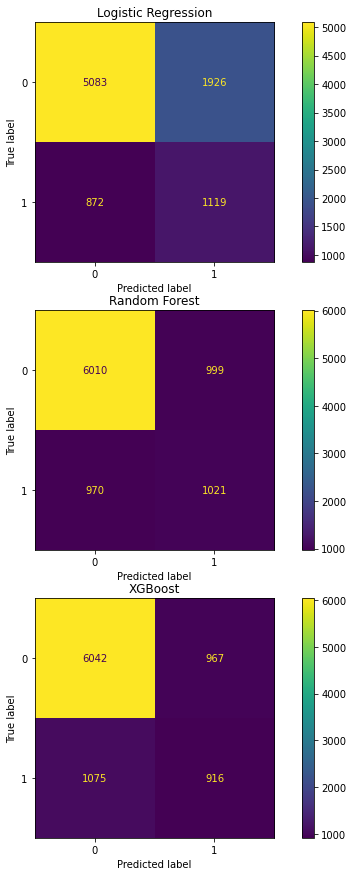

In [ ]:
# Plot confusion matrix of 3 models

fig,ax=plt.subplots(3,1, figsize=(10,15))

plot_confusion_matrix(lr_best, X_test_std, y_test, ax = ax[0], values_format="d")
ax[0].set_title("Logistic Regression")

plot_confusion_matrix(rf_best, X_test, y_test, ax = ax[1], values_format="d")
ax[1].set_title("Random Forest")

plot_confusion_matrix(xgb_random, X_test, y_test, ax = ax[2], values_format="d")
ax[2].set_title("XGBoost")

#### ROC_AUC Curve

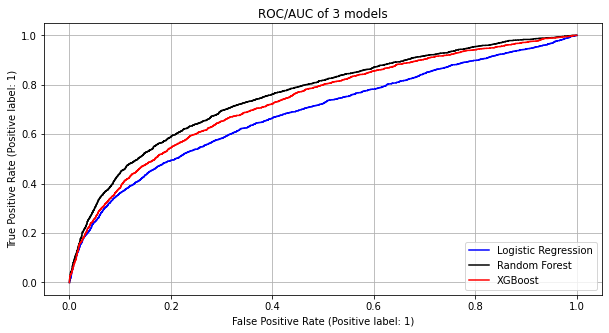

In [ ]:
# Plot ROC_AUC curve of 3 models
 
fig,ax=plt.subplots(figsize=(10,5))

plot_roc_curve(lr_best, X_test_std, y_test,ax=ax, color="blue",label='Logistic Regression')
plot_roc_curve(rf_best, X_test, y_test,ax=ax, color="black",label='Random Forest')
plot_roc_curve(xgb_random, X_test, y_test,ax=ax, color="red",label='XGBoost')

plt.title('ROC/AUC of 3 models')
plt.grid()

#### Precision_Recall Curve

Since the classes are imbalanced, precision_recall curve is more approriate.

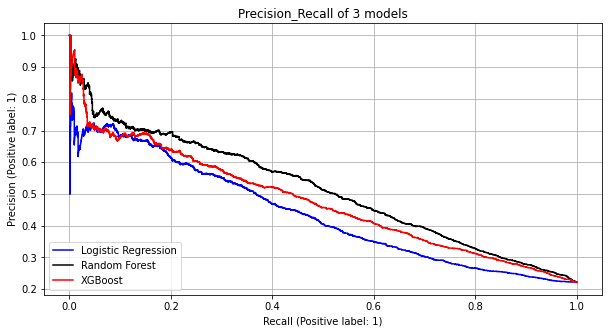

In [ ]:
# Compare 3 models' Precision_recall curves

fig,ax=plt.subplots(figsize=(10,5))

plot_precision_recall_curve(lr_best, X_test_std, y_test, ax=ax,color="blue",label='Logistic Regression')
plot_precision_recall_curve(rf_best, X_test, y_test, ax=ax,color="black",label='Random Forest')
plot_precision_recall_curve(xgb_random, X_test, y_test, ax=ax,color="red",label='XGBoost')

plt.title('Precision_Recall of 3 models')
plt.grid()

The performance all 3 models. Logistic Regression model has the best recall and Random Forest has the best Precision_Recall balance. 

In [ ]:
Final_result = Logistic_Regression_Model.append(RandomForest_model, ignore_index=True)
Final_result = Final_result.append(XGBoost_model, ignore_index=True)
Final_result.sort_values(by=['F1 Score','roc_auc Score'], ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,roc_auc Score
1,Random Forest,0.781222,0.505446,0.512808,0.509100,0.905165
2,XGBoost,0.773111,0.486458,0.460070,0.472896,0.886867
0,Logistic Regression,0.689111,0.367488,0.562029,0.444400,0.797052


In [ ]:
# Final_result = Final_result.drop(data.index[[2]])
# Final_result = Final_result.drop(data.index[range(0,4)])
# Final_result = Final_result.drop(labels='roc_auc Score', axis=1)
# Final_result

#### Model Recommendation

We recommend recall = 0.8, however, the threshold can be adjusted to reach higher recall.

In [ ]:
# Compute precision, recall and threshold of Random Forest

y_predict_rf = rf_best.predict_proba(X_test)
y_scores_rf = y_predict_rf[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_rf)

recalls_80 = recalls[np.argmin(recalls >= 0.80)]               # Recommend recall score = 0.8
precision_80 = precisions[np.argmin(recalls >= 0.80)]
threshold_80_recall = thresholds[np.argmin(recalls >= 0.80)]

thresholds = np.append(thresholds, 1)

recalls_80, precision_80, threshold_80_recall


(0.7995981918633852, 0.3277743463043031, 0.2558953823953824)

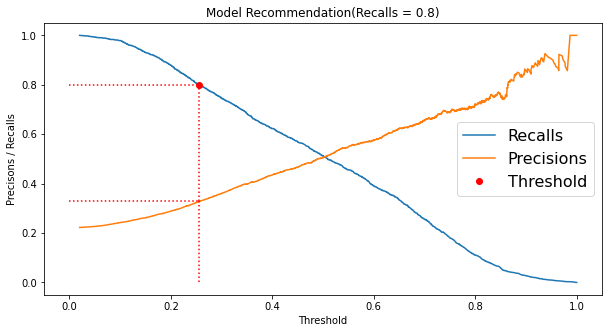

In [ ]:
# Plot recommended recall = 0.8

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(thresholds, recalls, label='Recalls')
ax.plot(thresholds, precisions, label='Precisions')

ax.plot([threshold_80_recall, threshold_80_recall], [precision_80, recalls_80], "r:" )
ax.plot([threshold_80_recall, threshold_80_recall], [0, precision_80], "r:")
ax.plot([0, threshold_80_recall], [precision_80, precision_80], "r:")
ax.plot([0, threshold_80_recall], [recalls_80, recalls_80], "r:")
ax.plot([threshold_80_recall], [recalls_80], "ro", label='Threshold')

ax.set_xlabel('Threshold')
ax.set_ylabel('Precisons / Recalls')
ax.legend(loc='center right',fontsize=16)
plt.title('Model Recommendation(Recalls = 0.8)')
plt.savefig('recommended_recall')
plt.show()


#### Feature Importances

Text(0.5, 1.0, 'Features importance')

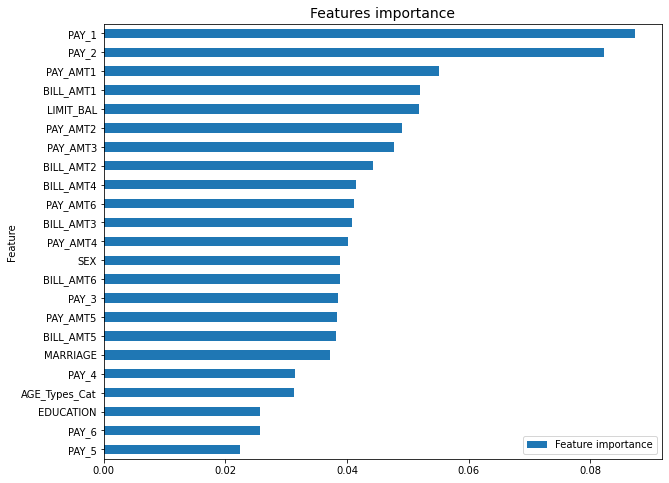

In [ ]:
# Plot feature importance of winner model - Random Forest

fea_df = pd.DataFrame({'Feature': feature_cols, 'Feature importance': rf_best.feature_importances_})
fea_df = fea_df.sort_values(by='Feature importance')

figure, ax = plt.subplots(figsize = (10,8))
fea_df.plot.barh(x='Feature',y='Feature importance', ax=ax)
plt.title('Features importance',fontsize=14)

"PAY_1" AND "Pay_2" are the most recent 2 months' payment status and they are the strongest predictors of future payment default risk.

## Conclusion

Logistic Regression model has the highest recall but the lowest precision, if the business cares recall the most, then this model is the best candidate. If the balance of recall and precision is the most important metric, then Random Forest is the ideal model. Since Random Forest has slightly lower recall but much higher precision than Logistic Regression, I would recommend Random Forest. 